# 1 交叉验证: 评估（衡量）机器学习模型的性能

#### 交叉验证

- 在未设置验证集的情况下，根据模型在测试集上的表现持续优化模型参数，这一过程可能使得模型在测试集上存在过拟合，因为上述过程中测试集的知识可以“泄漏”到模型中，并且评估指标不再报告泛化性能。


- 为了解决这个问题，数据集的某一部分可以作为验证集：模型训练完成以后，在验证集上对模型进行评估，当模型在验证集上性能较好时，最后在测试集上完成评估。


- 然而，通过将原始数据分为3个数据集合就大大减少了可用于模型学习的样本数量，并且得到的结果依赖于集合对（训练，验证）的随机选择。解决这个问题的方法是做交叉验证(简称CV)。测试集仍应保留以供最终评估，但不再需要建立专属的验证集。


- k-fold交叉验证过程如下：
训练集被不重复地划分（均分）为k份，将每个子集分别做一次验证集，其余的K-1组子集作为训练集，由此得到K个模型，这K个模型的分类准确率的平均数作为此K-CV下分类器的性能指标。

In [1]:
import numpy as np
import pandas as pd
pd.set_option("precision",6)
np.set_printoptions(precision=6)

from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


cancer = load_breast_cancer()
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2018)
clf_xgb = XGBClassifier().fit(X_train, y_train)

### 1.1 cross_val_score返回模型交叉验证的分数，有助于准确了解模型的性能

#### API
model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)

参数scoring只能取单个值

### 参数scoring
#### 包含scoring参数的函数
sklearn.model_selection.GridSearchCV

sklearn.model_selection.RandomizedSearchCV

sklearn.model_selection.cross_validate

sklearn.model_selection.cross_val_score

sklearn.model_selection.learning_curve

sklearn.model_selection.validation_curve

sklearn.model_selection.permutation_test_score

#### scoring参数的取值
http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [2]:
from sklearn.model_selection import cross_val_score
metric = ["accuracy", "roc_auc", "average_precision", "f1"]

# 参数scoring只能取单个值
scores = [cross_val_score(clf_xgb, X_train, y_train, scoring=i, cv=5) for i in metric]
result = [("%0.3f (+/- %0.3f)" % (i.mean(), i.std())) for i in scores]

scores_df = pd.DataFrame(result, index=metric, columns=['Score'])
scores_df.index.set_names("Metrics", inplace=True)
scores_df

,Score
Metrics,
accuracy,0.960 (+/- 0.016)
roc_auc,0.991 (+/- 0.013)
average_precision,0.994 (+/- 0.010)
f1,0.969 (+/- 0.012)


### 1.2 model_selection.cross_validate：返回模型的训练时长和分数信息

#### API  
model_selection.cross_validate(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’, return_train_score=’warn’)

##### 返回一个字典，包含以下信息
1) test_score: The score array for test scores on each cv split.

2) train_score: The score array for train scores on each cv split. This is available only if return_train_score parameter is True.

3) fit_time: The time for fitting the estimator on the train set for each cv split.

4) score_time: The time for scoring the estimator on the test set for each cv split. (注：return_train_score无论是否设置为True，都不会返回训练集的评分时间)

In [3]:
# 参数scoring能取多个值，可用列表或元组形式输入
from sklearn.model_selection import cross_validate
scores = cross_validate(clf_xgb, X_train, y_train, scoring=metric, return_train_score=True)
scores 

{'fit_time': array([ 0.080217,  0.048279,  0.068588]),
 'score_time': array([ 0.005009,  0.01    ,  0.004011]),
 'test_accuracy': array([ 0.93007 ,  0.950704,  0.950355]),
 'test_average_precision': array([ 0.983104,  0.984866,  0.996406]),
 'test_f1': array([ 0.943182,  0.961326,  0.961749]),
 'test_roc_auc': array([ 0.97631 ,  0.980496,  0.993734]),
 'train_accuracy': array([ 1.,  1.,  1.]),
 'train_average_precision': array([ 1.,  1.,  1.]),
 'train_f1': array([ 1.,  1.,  1.]),
 'train_roc_auc': array([ 1.,  1.,  1.])}

In [4]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision,test_f1,train_f1
0,0.080217,0.005009,0.930070,1.0,0.976310,1.0,0.983104,1.0,0.943182,1.0
1,0.048279,0.010000,0.950704,1.0,0.980496,1.0,0.984866,1.0,0.961326,1.0
2,0.068588,0.004011,0.950355,1.0,0.993734,1.0,0.996406,1.0,0.961749,1.0


### 1.3 cross_val_predict:通过交叉验证获取预测值

#### API
- [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict)

- model_selection.cross_val_predict(estimator, X, y=None, groups=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’, method=’predict’)

In [5]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(clf_xgb, X_train, y_train, cv=5) 
acc = metrics.accuracy_score(y_train, y_pred)
print("Accuracy : %.3f" % acc)

Accuracy : 0.960


## 1.4 多种交叉验证

#### 1.4.1 K-fold: K-折交叉验证

In [6]:
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d","e","f"]

#将X分为3份，2份作为训练集，剩余1份作为验证集
kf = KFold(n_splits=3)  
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[2 3 4 5] [0 1]
[0 1 4 5] [2 3]
[0 1 2 3] [4 5]


#### 1.4.2 StratifiedKFold: 分层 k 折
StratifiedKFold 是k-fold的变种,每个小集合中标签类别比例近似于完整训练集中的比例

In [7]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(10)
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[2 3 6 7 8 9] [0 1 4 5]
[0 1 3 4 5 8 9] [2 6 7]
[0 1 2 4 5 6 7] [3 8 9]


#### 1.4.2 RepeatedKFold:重复 K-折交叉验证

In [8]:
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])

rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=123)
for train, test in rkf.split(X):
    print("%s %s" % (train, test))

[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]


#### 1.4.3 留一交叉验证 (LOO)

In [9]:
# 只留一个样本作为验证集
from sklearn.model_selection import LeaveOneOut

X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


#### 1.4.4 理解model_selection.ShuffleSplit

##### Class sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=’default’, train_size=None, random_state=None)

##### 类的方法：split(X, y=None, groups=None)：返回训练集和测试集在被划分数据集X中的索引

In [10]:
from sklearn.model_selection import ShuffleSplit


X, y = load_breast_cancer(return_X_y=True)
rs = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)
for train_index, test_index in rs.split(X, y):
    print(train_index.shape, train_index.max(), train_index.min()) 
    print(test_index.shape, test_index.max(), test_index.min()) 
    print("**********************")

(426,) 568 0
(143,) 567 1
**********************
(426,) 568 0
(143,) 567 1
**********************
(426,) 568 0
(143,) 566 3
**********************


##### 将ShuffleSplit类作为cross_val_score中的cv参数

In [11]:
# cv=rs不是指将数据集划分为n_splits等份，而是根据ShuffleSplit函数中的参数test_size来划分n_splits份数据
rs = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf_xgb, X_train, y_train, cv=rs)

array([ 0.9375  ,  0.953125,  0.96875 ,  0.953125,  0.960938])

# 2 模型评估: 量化预测的质量

## 2.1 分类指标

### 2.1.1 精确度得分

In [12]:
from sklearn.metrics import accuracy_score

y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
print(accuracy_score(y_true, y_pred)) #返回正确率
print(accuracy_score(y_true, y_pred, normalize=False))  #返回分类正确的个数

0.5
2


### 2.1.2 Cohen’s kappa

In [13]:
from sklearn.metrics import cohen_kappa_score

y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cohen_kappa_score(y_true, y_pred)

0.4285714285714286

### 2.1.3 混淆矩阵

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_true = [1, 0, 1, 0, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

conf_mat = confusion_matrix(y_true, y_pred)
conf_mat

array([[2, 1],
       [1, 2]], dtype=int64)

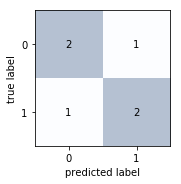

In [15]:
fig, ax = plot_confusion_matrix(conf_mat)
plt.show()

### 2.1.4 分类报告

In [16]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.67      1.00      0.80         2
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.50      0.67         2

avg / total       0.67      0.60      0.59         5



### 2.1.5 精准，召回和 F-measures

In [17]:
from sklearn import metrics
y_pred = [0, 1, 0, 0]
y_true = [0, 1, 0, 1]

In [18]:
print('precision_score : %.2f'% metrics.precision_score(y_true, y_pred))
print('recall_score : %.2f' % metrics.recall_score(y_true, y_pred))
print('f1_score : %.2f' % metrics.f1_score(y_true, y_pred))  
print('fbeta_score : %.2f' % metrics.fbeta_score(y_true, y_pred, beta=0.5))  
print('fbeta_score : %.2f' % metrics.fbeta_score(y_true, y_pred, beta=1))  
print('fbeta_score : %.2f' % metrics.fbeta_score(y_true, y_pred, beta=2)) 
print('precision_recall_fscore_support : \n', metrics.precision_recall_fscore_support(y_true, y_pred, beta=0.5))

precision_score : 1.00
recall_score : 0.50
f1_score : 0.67
fbeta_score : 0.83
fbeta_score : 0.67
fbeta_score : 0.56
precision_recall_fscore_support : 
 (array([ 0.666667,  1.      ]), array([ 1. ,  0.5]), array([ 0.714286,  0.833333]), array([2, 2], dtype=int64))


### 2.1.6 F1_Score

In [19]:
from sklearn.metrics import f1_score
y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 1, 0, 0, 1]

- 宏平均F1的计算方法先对每个类别单独计算F1值，再取这些F1值的算术平均值作为全局指标。

- 而微平均F1的计算方法是先累加计算各个类别的a、b、c、d的值，再由这些值求出F1值。

- 对比：宏平均F1平等对待每一个类别，所以它的值主要受到稀有类别的影响，而微平均F1受到常见类别的影响比较大

In [20]:
f1_score(y_true, y_pred, average='macro')   #分别把0/1当成正样本，求各自的F1,再求算术平均,不考虑样本比例

0.82857142857142851

In [21]:
f1_score(y_true, y_pred, average='micro')   #分别把0/1当成正样本，求总的F1

0.83333333333333337

In [22]:
f1_score(y_true, y_pred, average='weighted')   #求0/1各自在训练集中的比例构成向量w，然后分别把0/1当成正样本，求各自的F1，则w*f1

0.83809523809523812

In [23]:
f1_score(y_true, y_pred, average=None)  #分别把0/1当成正样本，各自的F1

array([ 0.8     ,  0.857143])

#### average默认取'binary'，把1当成正样本，再求F1

In [24]:
f1_score(y_true, y_pred, average='binary')  

0.8571428571428571

### 2.1.7 roc_curve、auc、roc_auc_score

#### 计算公式
FPR=FP/(FP+TN) 

TPR=TP/(TP+FN)  
predict_proba:模型预估各样本为正样本的概率 ;predict_proba >= thresholds时，样本为正样本  

一个模型对应于一条ROC曲线
不同的阈值对应于ROC曲线上不同的点

In [25]:
import numpy as np
from sklearn.metrics import roc_curve,auc,roc_auc_score

y_true = np.array([0, 0, 1, 1, 0, 1])
predict_proba= np.array([0.1, 0.4, 0.35, 0.8, 0.46 ,0.76])

#### metrics.roc_curve : 根据y_true、predict_proba返回FPR、TPR、thresholds

In [26]:
FPR, TPR, thresholds = roc_curve(y_true, predict_proba, pos_label=1) 
roc_curve_point = pd.DataFrame({'FPR':FPR,'TPR':TPR,'thresholds':thresholds}).round(3).iloc[:,[1,0,2]]
roc_curve_point

,TPR,FPR,thresholds
0,0.333,0.000,0.80
1,0.667,0.000,0.76
2,0.667,0.667,0.40
3,1.000,0.667,0.35
4,1.000,1.000,0.10


#### metrics.auc(FPR, TPR) : 根据FPR、TPR计算AUC

In [27]:
auc(FPR, TPR)

0.77777777777777779

#### metrics.roc_auc_score(y_true、predict_proba):根据y_true、predict_proba直接计算AUC

In [28]:
roc_auc_score(y_true, predict_proba)

0.77777777777777779

### 2.1.8 precision_recall_curve与average_precision_score

#### average_precision_score:根据y_true, probas_pred求PRC曲线下的面积

In [29]:
from sklearn.metrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
probas_pred = np.array([0.1, 0.4, 0.35, 0.8])

average_precision_score(y_true,probas_pred)  

0.83333333333333326

#### metrics.precision_recall_curve ：根据y_true, probas_pred返回precision, recall, thresholds

In [30]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, probas_pred)
print(thresholds)

prc_point = pd.DataFrame({'precision':precision,'recall':recall}).round(3)
prc_point

[ 0.35  0.4   0.8 ]


,precision,recall
0,0.667,1.0
1,0.500,0.5
2,1.000,0.5
3,1.000,0.0


## 3 回归指标

### 3.1 解释方差得分

In [31]:
from sklearn.metrics import explained_variance_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
explained_variance_score(y_true, y_pred)  

0.95717344753747324

In [32]:
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
explained_variance_score(y_true, y_pred, multioutput='raw_values')

array([ 0.967742,  1.      ])

In [33]:
explained_variance_score(y_true, y_pred, multioutput=[0.3, 0.7])

0.99032258064516121

### 3.2 平均绝对误差

In [34]:
from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_absolute_error(y_true, y_pred)

0.5

In [35]:
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
mae=mean_absolute_error(y_true, y_pred)
mae1=mean_absolute_error(y_true, y_pred, multioutput='raw_values')
mae2=mean_absolute_error(y_true, y_pred, multioutput=[0.3, 0.7])
print(mae,mae1,mae2)

0.75 [ 0.5  1. ] 0.85


### 3.3 均方误差

In [36]:
from sklearn.metrics import mean_squared_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_squared_error(y_true, y_pred)

0.375

In [37]:
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
mean_squared_error(y_true, y_pred)  

0.70833333333333337

### 3.4 均方误差对数

In [38]:
from sklearn.metrics import mean_squared_log_error
y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
mean_squared_log_error(y_true, y_pred)  

0.039730122984593788

In [39]:
y_true = [[0.5, 1], [1, 2], [7, 6]]
y_pred = [[0.5, 2], [1, 2.5], [8, 8]]
mean_squared_log_error(y_true, y_pred)

0.044199361889160536

### 3.5  R² score(可决系数)

##### klearn.metrics.r2_score(y_true, y_pred, sample_weight=None, multioutput=’uniform_average’)
注意参数顺序，y_true, y_pred不能弄反

In [40]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
r2_score(y_true, y_pred)

0.94860813704496794

In [41]:
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
r2_score(y_true, y_pred, multioutput='variance_weighted')

0.93825665859564167

In [42]:
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
rs1 = r2_score(y_true, y_pred, multioutput='uniform_average')
rs2 = r2_score(y_true, y_pred, multioutput='raw_values')
rs3 = r2_score(y_true, y_pred, multioutput=[0.3, 0.7])
print(rs1, rs2, rs3)

0.936800526662 [ 0.965438  0.908163] 0.92534562212
